# Classification of Hyperspectral Data with Principal Components Analysis (PCA) in Python
## Adapted from here: https://www.neonscience.org/classification-pca-python
### AUTHORS: Paul Gader
In this tutorual, we'll reduce the number of features in a hyperspectral image using the Principal Components Analysis (PCA) method.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import io
from mpl_toolkits.mplot3d import Axes3D

### First, we'll look at how to define a function in Python:
There are several components needed to define a function in Python, including the def keyword, function name, parameters (inputs), and the return statement, which specifies the output of the function.

    def function_name(parameter):
        some code here    
        return output
        
To apply "some code here" to parameter MyParam, you just type:

    function_name(parameter = MyParam)
    
*Learn more about functions in Python here: https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/functions-modular-code/write-functions-in-python/*

This function lets us plot the spectral signature of an image, with mean reflectance plotted in red:

In [3]:
def PlotSpectraAndMean(Spectra, Wv, fignum):
    #The function "PlotSpectraAndMean" plots the spectrum of a multivariate image. It takes 3 parameters as inputs:
    # Spectra: vector of reflectance values for each band (as concantonated rows). Spectra is NBands x NSamps
    # Wv: wavelengths of NBands
    # fignum: plt.figure formatting parameter
    
    ### Spectra is NBands x NSamps
    mu = np.mean(Spectra, axis=1) #calculates the mean value of spectra
    print(np.shape(mu)) #prints out shape of mu, mean reflectance across bands, should be vector of lengt NSamp
    plt.figure(fignum) #sets plt.figure parameter
    plt.plot(Wv, Spectra, 'c') # plots "Spectra" in cyan ('c')
    plt.plot(Wv, mu, 'r') # plots "mu" in red ('r')
    plt.show() # print plot
    return mu # print mu

### Load data
In this tutorial, we're using a very small hyperspectral image downloaded from the NEON dataset:

https://data.neonscience.org/

In [4]:
filename   = './RSDI2017-Data-SpecClass/OSBSTinyIm.mat'
ImDict     = io.loadmat(filename)
OSBSTinyIm = ImDict['OSBSTinyIm']
TinySize   = np.shape(OSBSTinyIm)
NRows      = TinySize[0]
NCols      = TinySize[1]
NBands     = TinySize[2]
print('{0:4d} {1:4d} {2:4d}'.format(NRows, NCols, NBands))

  62  194  346


## TASK 1: How many bands are in (OSBSTinyIm)?

Now we want to know the specific wavelengths for the spectra bands in OSBSTinyIm:

(346, 1)


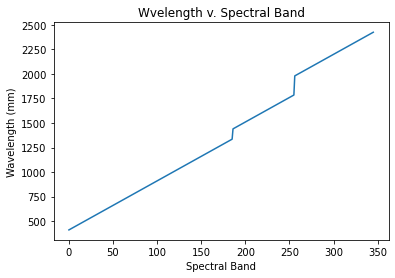

In [5]:
### LOAD WAVELENGTHS WITH WATER BANDS ###
Wv = io.loadmat("./RSDI2017-Data-SpecClass/NEONWvsNBB")
Wv = Wv['NEONWvsNBB']
print(np.shape(Wv))

plt.figure(1)
plt.plot(range(346), Wv)
plt.ylabel('Wavelength (mm)')
plt.xlabel('Spectral Band')
plt.title('Wvelength v. Spectral Band')
plt.show()

## TASK 2: Add a descriptive title, y axis label, and x axis label to this plot (hint: plt.ylabel()... )

In [6]:
### HAVE TO SUBTRACT AN OFFSET BECAUSE OF BAD BAND REMOVAL AND 0-BASED Python vs 1-Based MATLAB   ###
Offset     = 7

### LOAD & PRINT THE INDICES FOR THE COLORS   ###
### AND DIG THEM OUT OF MANY LAYERS OF ARRAYS ###
NEONColors = io.loadmat('./RSDI2017-Data-SpecClass/NEONColors.mat')
#This is a MAT-file, generated in matlab. Learn more about it before we move on:
print(NEONColors)


NEONRed    = NEONColors['NEONRed']
NEONGreen  = NEONColors['NEONGreen']
NEONBlue   = NEONColors['NEONBlue']
NEONNir    = NEONColors['NEONNir']
NEONRed    = NEONRed[0][0]-Offset
NEONGreen  = NEONGreen[0][0]-Offset
NEONBlue   = NEONBlue[0][0]-Offset
NEONNir    = NEONNir[0][0]-Offset
print('Indices:     {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRed, NEONGreen, NEONBlue, NEONNir))

### CONVERT THE INDICES TO WAVELENGTHS ###
NEONRedWv    = Wv[NEONRed][0]
NEONGreenWv  = Wv[NEONGreen][0]
NEONBlueWv   = Wv[NEONBlue][0]
NEONNirWv    = Wv[NEONNir][0]
print('Wavelengths: {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRedWv, NEONGreenWv, NEONBlueWv, NEONNirWv))

print("When read into Python, the MAT-file is turned into a: ") 
type(NEONColors['NEONRed'])

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Jun 20 03:14:00 2017', '__version__': '1.0', '__globals__': [], 'NEONBlue': array([[13]], dtype=uint8), 'NEONGreen': array([[32]], dtype=uint8), 'NEONNir': array([[126]], dtype=uint8), 'NEONRed': array([[54]], dtype=uint8)}
Indices:       47   25    6  119
Wavelengths:  645  535  440 1005
When read into Python, the MAT-file is turned into a: 


numpy.ndarray

Using the RGB bands specified in NEONColors index file, we'll plot a RBG composite representation of OSBSTinyIm.

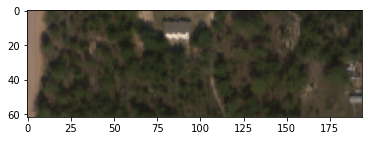

In [7]:
RGBIm = OSBSTinyIm[:, :, [NEONRed, NEONGreen, NEONBlue]]
RGBIm = np.sqrt(RGBIm) 
plt.figure(2)
plt.imshow(RGBIm)
plt.show()

## TASK 3: What does np.sqrt do to this image? 
## How many dimensions were in RBGIm before np.sqrt? 
## How many dimensions were in RBGIm after np.sqrt? 
## What does plt.imshow do? 
## What happens if we don't use np.sqrt?

One way to think about a raster dataset is that every individual pixel, or cell, is an object. Just like with our vector spatial data, each spatial object has a row of value(s) associated with it in the attribute table, viewing each pixel as a distinct spatial object (record) us to create a similar dataframe, where rows represent unique pixels and columns represent multivariate observations at that pixel location. 

In order to rearrange the raster back from the dataframe, we'll need to keep careful check of where our rows and columns have lined up.

Since we read a Matlab object into Python, there will be a few translational differences that need to be taken into account. Above, we saw that on issue arrises with different indexing values (the first item in a series is "0" in Python, "1" in Matlab). There are also differences in how an array is concantonated into a vector:

In [8]:
### HAVE TO TAKE INTO ACCOUNT DIFFERENCES BETWEEN Python AND Matlab ###
### Python USES THE    C     PROGRAMMING LANGUAGE ORDERING ###
### MATLAB USERS THE FORTRAN PROGRAMMING LANGUAGE ORDERING ###
### Python WOULD RESHAPE BY REFERENCE AND MATLAB BY VALUE  ###
### THEREFORE, WE NEED TO COPY THE VALUES EXPLICITLY       ###
TinyVecs = OSBSTinyIm.reshape(NRows*NCols, NBands, order='F').copy()

### MATLAB TREATS THE ROWS AS DATA SAMPLES ###
### np  TREATS THE COLS AS DATA SAMPLES ###
TinyVecs = np.transpose(TinyVecs)
NSamps   = np.shape(TinyVecs)[1]
np.shape(TinyVecs)

(346, 12028)

But representing our data in this way allows us to plot the image's spectral signature, like below:

(346,)


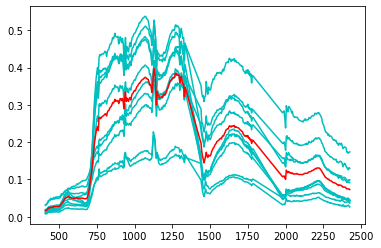

In [9]:
#Using the function "PlotSpectraAndMean", defined above.
SpecIndices = range(1000, 2000, 100)
SomeSpectra = TinyVecs[:, range(1000, 2000, 100)]
mymu        = PlotSpectraAndMean(SomeSpectra, Wv, 3)

In [10]:
np.shape(mymu)

(346,)

## TASK 4: Edit the plot to label the y and x axis, using code below:

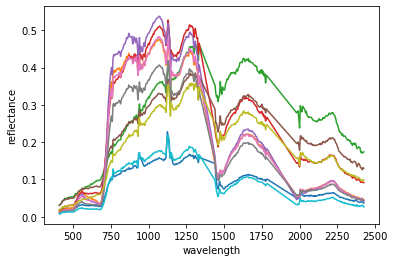

In [13]:
### Indices of Spectra to Try ###
### SpecIndices = range(0, 1000, 100) ###
SpecIndices = range(1000, 2000, 100)
SomeSpectra = TinyVecs[:, range(1000, 2000, 100)]
plt.figure(3)
plt.plot(Wv, SomeSpectra)
plt.xlabel('wavelength')
plt.ylabel('reflectance')
plt.show()

When we look at the data, we can see instances where the average reflectance of nearby (on the electromagnetic spectrum) bands tend to be similar to each other. This represents a form of collinearity in our data: it's an instance where we lack good cross-replication.

We can approximate the degree of collinearity between spectral bands by quantifying its ***covariance matrix:***

In the ***covariance matrix***, we calculate pairwise the joint probability of two random variables (in units of reflectance squared). Higher values indicate more covariance.

On diagonal, we're essentially measuring the covariance of a variable with itself, which is equal to the variable's variance.

In [14]:
print(np.shape(TinyVecs))
C = np.cov(TinyVecs)
print(np.shape(C))
print(C)

(346, 12028)
(346, 346)
[[0.00107813 0.00112086 0.00117217 ... 0.00316054 0.00336773 0.00343459]
 [0.00112086 0.00116682 0.00121987 ... 0.0032881  0.0035036  0.00357329]
 [0.00117217 0.00121987 0.00127652 ... 0.00344246 0.00366811 0.0037411 ]
 ...
 [0.00316054 0.0032881  0.00344246 ... 0.01039593 0.01107545 0.01130171]
 [0.00336773 0.0035036  0.00366811 ... 0.01107545 0.0118232  0.01206323]
 [0.00343459 0.00357329 0.0037411  ... 0.01130171 0.01206323 0.01231925]]


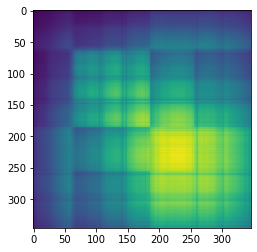

In [15]:
plt.figure(6)
plt.imshow(C)
plt.show()

### PCA
OK, let's do PCA

First, we'll calculate TinyVecsZ as the mean-subtracted version of the original spectra.

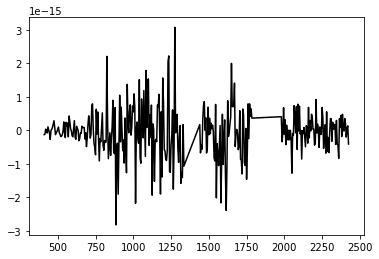

In [16]:
mu = np.mean(TinyVecs, axis=1)
TinyVecsZ = np.zeros((NBands, NSamps))
for n in range(NSamps):
    TinyVecsZ[range(NBands),n]= TinyVecs[(range(NBands), n)]-mu

muz = np.mean(TinyVecsZ, axis=1)
plt.figure(5)
plt.plot(Wv, muz, 'k')
#plt.ylim(-1,1)
plt.show()

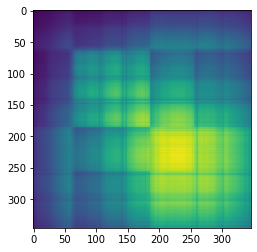

In [18]:
plt.figure(6)
plt.imshow(C)
plt.show()

Now, we'll calculate the covariance matrix on the norm of TinyVecs. Then, we'll computee the eigenvalues (D) and right eigenvectors (V) of the covariance matrix using the linalg.eig() function.

In [17]:
C   = np.cov(TinyVecsZ)
D,V = linalg.eig(C)
D   = D.real
print(np.shape(D))
print(np.shape(V))
print(TinyVecsZ.shape)
print(V[0,0])

(346,)
(346, 346)
(346, 12028)
-0.01248229145732035


### But what do these mean?
How do we interpret D and V in terms of our data?

The eigenvectors (V) and eigenvalues (D) of a covariance matrix represent the “core” of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude.

Plotting our eigenvalues gives us an idea how much variance in our total data is encoded in each eigenvector:


(346,)
(346,)


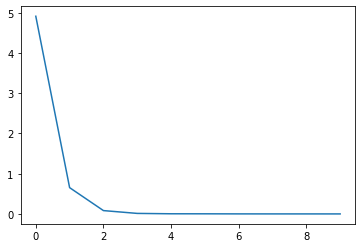

In [34]:
plt.figure(10)
print(D.shape)
DiagD = np.diag(D)
print(D.shape)
#plt.plot(DiagD)
#Exercise
plt.plot(D[range(10)])
#plt.plot(D[range(10, 30, 10)])
#plt.xlm(-1,5)
plt.show()

## TASK 5: In the cell above, try cancelling and uncancelling the different plt.plot() arguments. Based on the eigvenvalues, how many eigenvectors do we need to explain the vast majority of variance in our data?

## Projecting our data into Principal Component Space
By taking the dot product (np.dot) of the transpose of our eigenvectors (V.T) and our original data, we can project our data into the principal component pace TinyVecsPCA

In [35]:
TinyVecsPCA = np.dot(V.T, TinyVecsZ) 
PCACovar    = np.cov(TinyVecsPCA)
D,V         = linalg.eig(C)
D           = D.real
print(D.shape)
print(PCACovar.shape)
for r in range(10):
    print('{0:5f} {1:5f}'.format(D[r], PCACovar[r,r]))
print()
for r in range(10):
    for c in range(10):
        NextVal = int(10000*PCACovar[r,c])
        print('{0:5d}'.format(NextVal), end=" ")
    print('\n')
# #Delta       = np.sum(np.sum((PCACovar-D), axis=0), axis=0)
# print(Delta)
# plt.figure(11)
# plt.plot(np.diag(PCACovar))
# plt.show()

(346,)
(346, 346)
4.911250 4.911250
0.653442 0.653442
0.083168 0.083168
0.013260 0.013260
0.004038 0.004038
0.003201 0.003201
0.001390 0.001390
0.000931 0.000931
0.000705 0.000705
0.000561 0.000561

49112     0     0     0     0     0     0     0     0     0 

    0  6534     0     0     0     0     0     0     0     0 

    0     0   831     0     0     0     0     0     0     0 

    0     0     0   132     0     0     0     0     0     0 

    0     0     0     0    40     0     0     0     0     0 

    0     0     0     0     0    32     0     0     0     0 

    0     0     0     0     0     0    13     0     0     0 

    0     0     0     0     0     0     0     9     0     0 

    0     0     0     0     0     0     0     0     7     0 

    0     0     0     0     0     0     0     0     0     5 



Notice that the values on the diagonal are the variances of each coordinate in the PCA transformed data. They drop off rapidly which is why one can reduce dimensionality by discarding components that have low variance. Also, notice that the diagonal matrix D produce by diagonalizing the covariance of x is the covariance of y = PCA(x).

If the data are Gaussian, then the coordinates of y are uncorrelated and independent. If not, then only uncorrelated.

Let's pull out the first 3 dimensions and plot them.

<IPython.core.display.Javascript object>


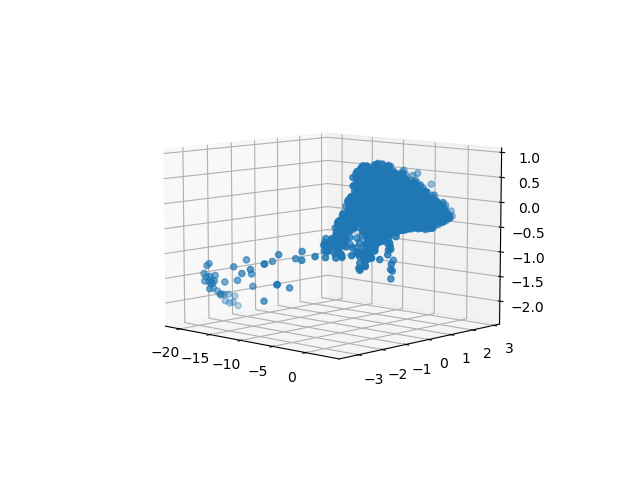

In [36]:
%matplotlib notebook
#note this % notation is an iPython magic command! It lets you act like you're running a terminal: more here https://ipython.readthedocs.io/en/stable/interactive/magics.html
fig = plt.figure(13)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(TinyVecsPCA[0,range(NSamps)],TinyVecsPCA[1,range(NSamps)],TinyVecsPCA[2,range(NSamps)], marker='o')
plt.show()

<IPython.core.display.Javascript object>


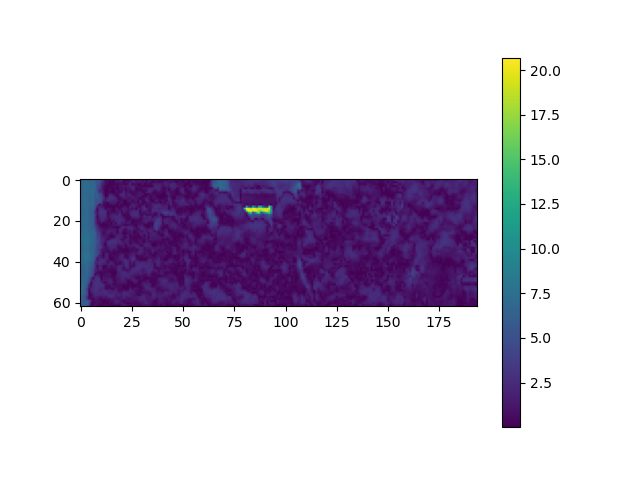

<IPython.core.display.Javascript object>


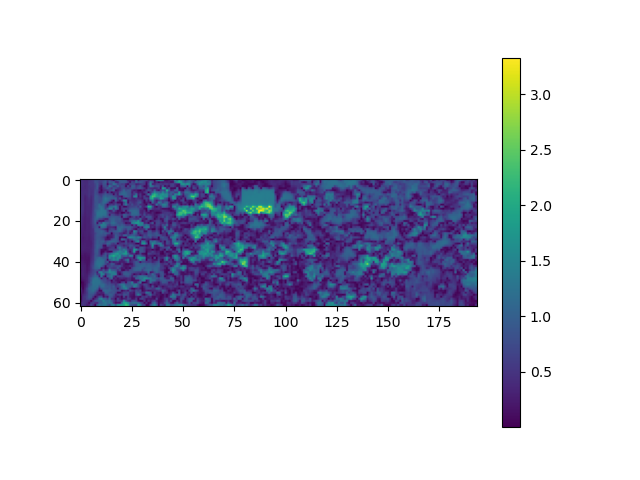

<IPython.core.display.Javascript object>


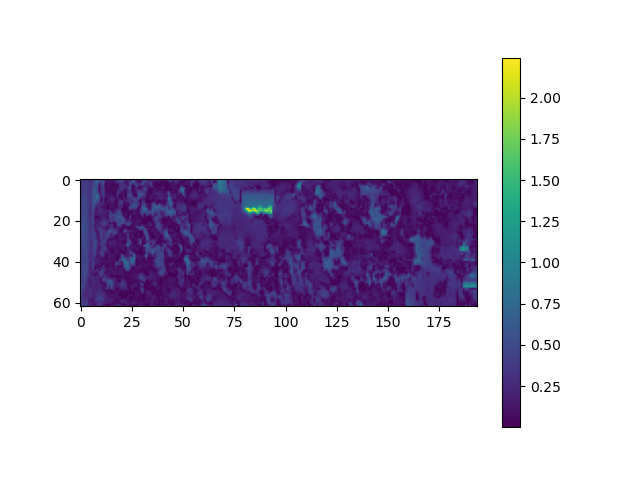

In [37]:
for coord in range(3):
    P1 = TinyVecsPCA[coord, :]
    PCAIm      = np.reshape(P1, (NRows, NCols), order='F')
    plt.figure(14+coord)
    plt.imshow(np.abs(PCAIm))
    plt.colorbar()
    plt.show()

### At the end of the day projecting your data into Principal Component space gives you a *reduced number* of features that are *uncorrelated*, but explain the *majority of variance in the data*

## TASK 6: Why is this important for inference?

## TASK 7: What is another way you can reduce the number of features (hint, use your scientific know-how?

### When you've completed this assignment, upload it onto Blackboard>coursework>Week 8 > PCA Assignment